# Electric Production Forecast by AR AM ARIMA SARIMA models

This project aims to model the Electric Production IP index in US using data from 1985 to 2017 (UCI Dataset).<br>
The notebook is organized as follows:<br>

- SARIMA:<br>
    - Data preparation for SARIMA: stationarity analysis, PACF, ACF
    - SARIMA modeling
    - SARIMA Prediction
    - SARIMA Forecast

## Custom Functions definition

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


from math import sqrt

plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


## data uploading

In [34]:
df=pd.read_csv('Electric_Production.csv',index_col='DATE',parse_dates=True) 

In [35]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


### name all columns in a DataFrame to a single column name, value. (work only because we had one column)

In [36]:
df.columns = ['value']

### Display the last 5 rows of a DataFrame.

In [37]:
df.tail()

,value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


In [39]:
frequency = pd.infer_freq(df.index)
print(f"Inferred Frequency: {frequency}")

Inferred Frequency: MS


##### There are no missing values!

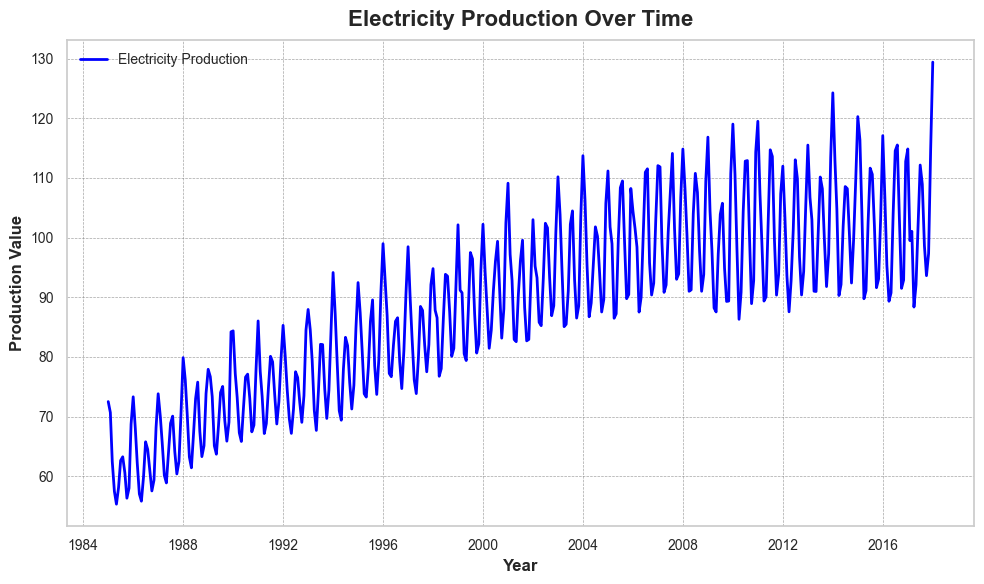

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

# Create the plot
plt.figure(figsize=(10, 6))  # Adjust figure size
plt.plot(df.index, df['value'], label='Electricity Production', color='blue', linewidth=2)

# Add title and labels
plt.title("Electricity Production Over Time", fontsize=16, weight='bold')
plt.xlabel("Year", fontsize=12)
plt.ylabel("Production Value", fontsize=12)

# Customize ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add a legend
plt.legend(fontsize=10, loc="upper left")

# Add grid
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.tight_layout()  # Adjust spacing
plt.show()


##### The data can be interpreted as a time series with a clear positive trend and seasonality.

### SARIMA modeling

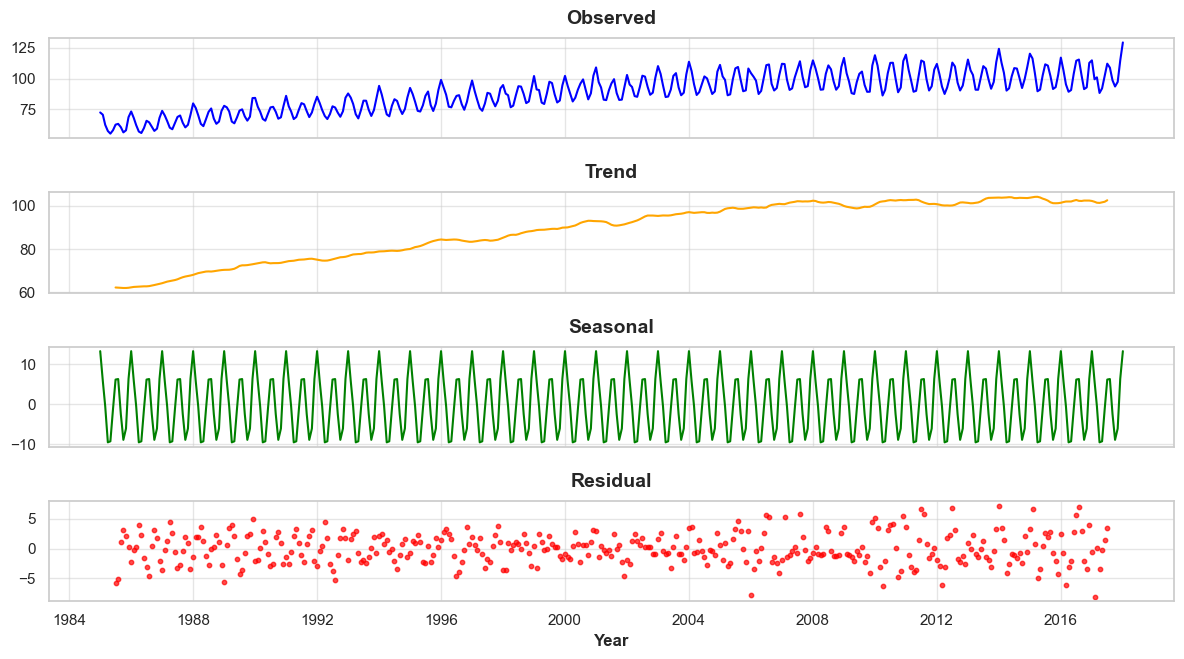

In [41]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Perform seasonal decomposition
result = seasonal_decompose(df['value'], model='additive', period=12)

# Create a figure with PowerPoint-friendly dimensions (16:9 aspect ratio)
fig, axes = plt.subplots(4, 1, figsize=(12, 6.75), sharex=True)
# Plot original series
axes[0].plot(df.index, result.observed, color='blue')
axes[0].set_title("Observed", fontsize=14)
axes[0].grid(alpha=0.5)

# Plot trend
axes[1].plot(df.index, result.trend, color='orange')
axes[1].set_title("Trend", fontsize=14)
axes[1].grid(alpha=0.5)

# Plot seasonal component
axes[2].plot(df.index, result.seasonal, color='green')
axes[2].set_title("Seasonal", fontsize=14)
axes[2].grid(alpha=0.5)

# Plot residuals as points
axes[3].scatter(df.index, result.resid, color='red', alpha=0.7, s=10)
axes[3].set_title("Residual", fontsize=14)
axes[3].grid(alpha=0.5)

# Add a shared x-axis label
plt.xlabel("Year", fontsize=12)
plt.tight_layout()
plt.show()


#### Observed:
Clearly displays the trend, seasonality, and noise components together.

##### Trend:
Highlights the long-term upward movement in the data.

##### Seasonal:
Repeats with a consistent periodic pattern, showing predictable seasonality.

##### Residual:
No clear pattern suggests that the decomposition worked well in isolating trend and seasonality.

#### check the stationarity of the time serie by performing the Augmented Dickey Fuller (ADF) test.

check the stationarity of a time series, the Augmented Dickey-Fuller (ADF) test
The ADF test checks for a unit root, where the null hypothesis ( \( H_0 \) ) is:

\( H_0 \): The series is not stationary. 
 
If the p-value < 0.05, we reject \( H_0 \) and conclude that the series is stationary.


In [42]:
# Perform the ADF test
result = adfuller(df['value'])
print("ADF Statistic:", result[0])
print("p-value:", result[1])
# Interpretation:
if result[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

ADF Statistic: -2.256990350047227
p-value: 0.1862146911658738
The series is not stationary (fail to reject the null hypothesis).


This means that the time serie is non stationary with a confidence of 95%. We check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series)

In [43]:
result=adfuller(df.value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')
# Interpretation:
if result[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

ADF Statistics:-7.104890882267301
p-value:4.0777865655397073e-10
The series is stationary (reject the null hypothesis).


##### Now the series looks stationary with a 1-order difference

###  ACF and PACF

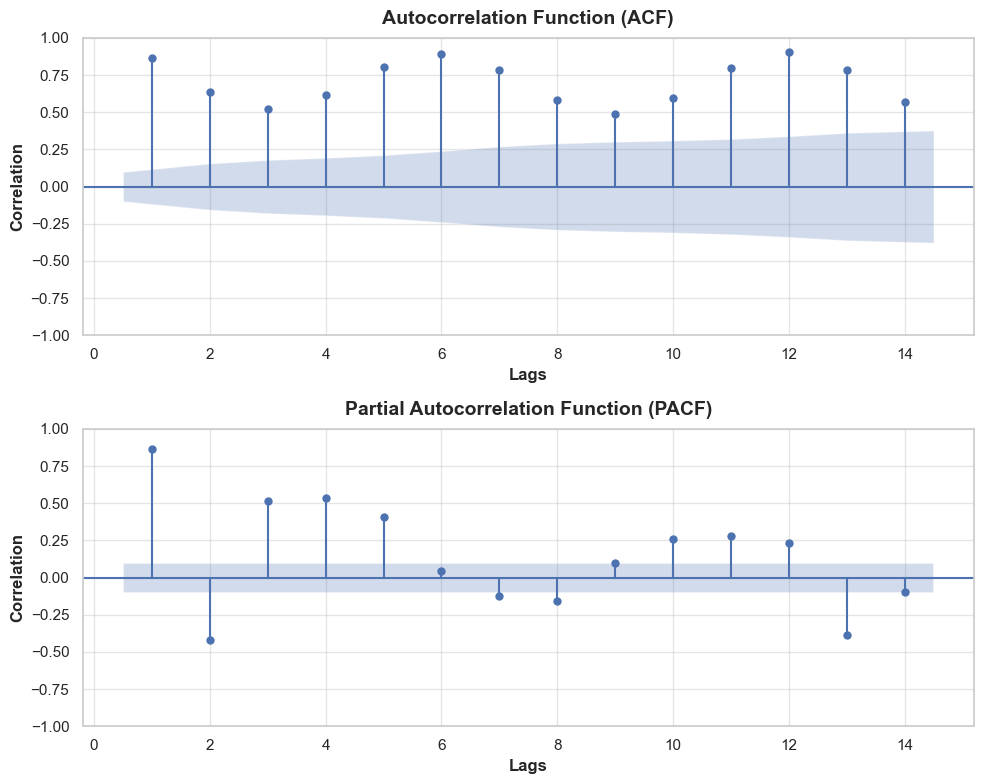

In [44]:
# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(df['value'], lags=14, zero=False, ax=ax1)
ax1.set_title("Autocorrelation Function (ACF)", fontsize=14, weight='bold')
ax1.set_xlabel("Lags", fontsize=12)
ax1.set_ylabel("Correlation", fontsize=12)
ax1.grid(alpha=0.5)

# Plot PACF
plot_pacf(df['value'], lags=14, zero=False, ax=ax2, method='ywm')  # 'ywm' ensures stability for large lags
ax2.set_title("Partial Autocorrelation Function (PACF)", fontsize=14, weight='bold')
ax2.set_xlabel("Lags", fontsize=12)
ax2.set_ylabel("Correlation", fontsize=12)
ax2.grid(alpha=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

## Interpretation of the ACF and PACF Plots

### ACF (Autocorrelation Function)

**Definition:** Measures the correlation of the time series with its lagged values.

**What the Plot Shows:**
- **Lag 1 to 6:** Strong positive autocorrelations (bars exceed the confidence interval), indicating persistence or memory in the series.
- **Lag 7 to 14:** Gradual decay in autocorrelation, suggesting that the series has long-term dependence but weakens over time.

**Conclusion:** This pattern is indicative of a time series with a trend or a non-stationary series (e.g., AR or ARIMA model may be appropriate after differencing).


### PACF (Partial Autocorrelation Function)

**Definition:** Measures the correlation of the time series with its lagged values, controlling for the influence of shorter lags.

**What the Plot Shows:**
- **Lag 1:** Strong partial autocorrelation, indicating a direct relationship with the previous time step.
- **Lag 2-3:** Some weaker partial autocorrelations, suggesting short-term relationships.
- **Lag 4-6-7-14:** The values are within the confidence intervals, indicating no significant partial autocorrelations at longer lags.
- **Lag 10 and 13:** indicate that these particular time steps have a direct influence on the current value, even after accounting for the contributions of the intermediate lags.
This could reflect periodic or seasonal effects, or some structure in the data that occurs every 10 or 13 lags.
**Conclusion:** The PACF suggests that the series may be modeled with a low-order AR term (likely AR(1) or AR(2)).


In [45]:
import sys
print(sys.prefix)

C:\Users\user\AppData\Local\Programs\Python\Python310


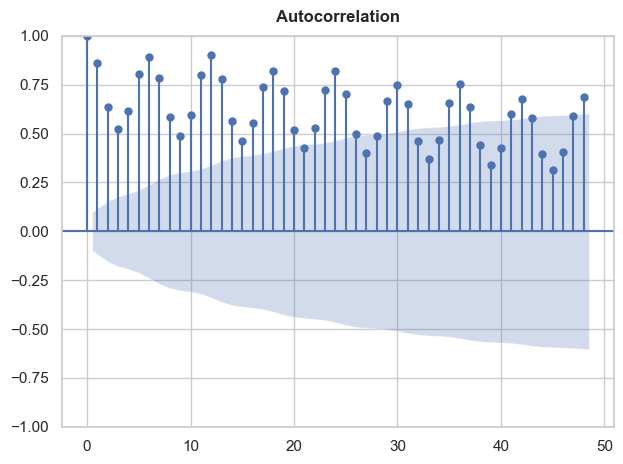

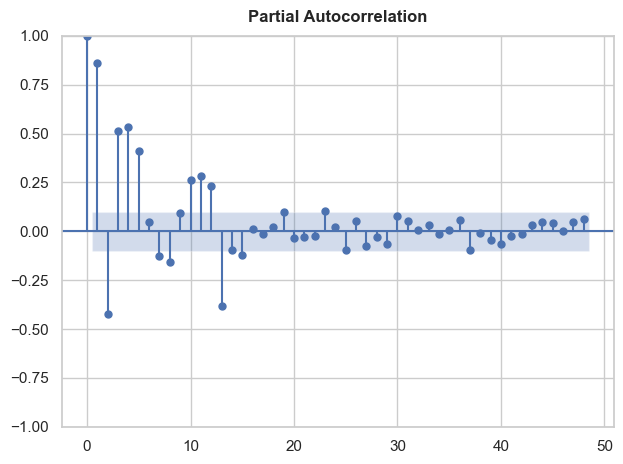

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df, lags=48)
plot_pacf(df, lags=48)
plt.show()

In [47]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(df, seasonal=True, m=6, trace=True)
print(stepwise_fit.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[6] intercept   : AIC=inf, Time=3.27 sec
 ARIMA(0,1,0)(0,0,0)[6] intercept   : AIC=2750.050, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[6] intercept   : AIC=2404.411, Time=0.37 sec
 ARIMA(0,1,1)(0,0,1)[6] intercept   : AIC=2570.187, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[6]             : AIC=2748.185, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[6] intercept   : AIC=2691.759, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[6] intercept   : AIC=inf, Time=1.02 sec
 ARIMA(1,1,0)(1,0,1)[6] intercept   : AIC=2106.184, Time=1.39 sec
 ARIMA(1,1,0)(0,0,1)[6] intercept   : AIC=2600.424, Time=0.37 sec
 ARIMA(1,1,0)(2,0,1)[6] intercept   : AIC=2020.198, Time=1.54 sec
 ARIMA(1,1,0)(2,0,2)[6] intercept   : AIC=inf, Time=2.93 sec
 ARIMA(1,1,0)(1,0,2)[6] intercept   : AIC=2057.836, Time=1.96 sec
 ARIMA(0,1,0)(2,0,1)[6] intercept   : AIC=2033.581, Time=2.49 sec
 ARIMA(2,1,0)(2,0,1)[6] intercept   : AIC=1986.972, Time=0.82 sec
 ARIMA(2,1,0)(1,0,1)[6] intercept   : AIC=2095.7

In [48]:
import pmdarima as pm

In [49]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
results=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.22 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.08 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.13 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=0.34 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=0.54 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=0.24 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.21 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=0.48 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=0.43 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

##### Best model:  ARIMA(2,1,1)(2,0,2)[6]          

##### Best model:  ARIMA(2,1,2)(1,1,2)[6]          


## Parameters Explained:

### Non-Seasonal ARIMA Terms:
- **d=1**: The order of differencing to make the series stationary (first differencing).
- **start_p=1, start_q=1**: Starting values for the AR (p) and MA (q) terms in the search.
- **max_p=3, max_q=3**: Maximum values for the AR (p) and MA (q) terms to search up to.

### Seasonal SARIMA Terms:
- **seasonal=True**: Indicates that the model should include a seasonal component (SARIMA).
- **m=6**: Specifies the seasonality period (e.g., 6 means a repeating pattern every 6 time steps).
- **D=1**: Seasonal differencing order to make the seasonal component stationary.
- **start_P=1, start_Q=1**: Starting values for the seasonal AR (P) and seasonal MA (Q) terms.
- **max_P=2, max_Q=2**: Maximum values for seasonal AR (P) and seasonal MA (Q) terms to search up to.

### Optimization Criteria:
- **information_criterion='aic'**: Uses the Akaike Information Criterion (AIC) to compare models. AIC balances model fit and complexity; lower AIC values indicate better models.

### Additional Parameters:
- **trace=True**: Prints the progress of the search (useful for debugging or monitoring).
- **error_action='ignore'**: Ignores errors during model fitting (e.g., when a specific combination of parameters fails).
- **stepwise=True**: Uses a stepwise search to reduce the computational cost by testing combinations iteratively instead of exhaustively.


In [50]:
df.index = pd.to_datetime(df.index)  # Ensure the index is a datetime object
df = df.asfreq('MS')  # 'MS' stands for Monthly Start

In [51]:
model=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
results=model.fit()

In [52]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Fri, 31 Jan 2025   AIC                           1814.177
Time:                                   17:31:59   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321      0.187      -0.137       0.702
ma.L1         -0.2982      0.337     -0.884      0.377      -0.960       0.363
ma.L2         -0.6397      0.329     -1.944      0.052      -1.285       0.005
ar.S.L6       -0.9976      0.003   -380.162      0.000      -1.003      -0.992
ma.S.L6        0.1145      0.040      2.832      0.005       0.035       0.194
ma.S.L12      -0.7764      0.037    -20.853      0.000      -0.849      -0.703
sigma2         5.5549      0.307     18.092      0.000       4.953       6.157
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

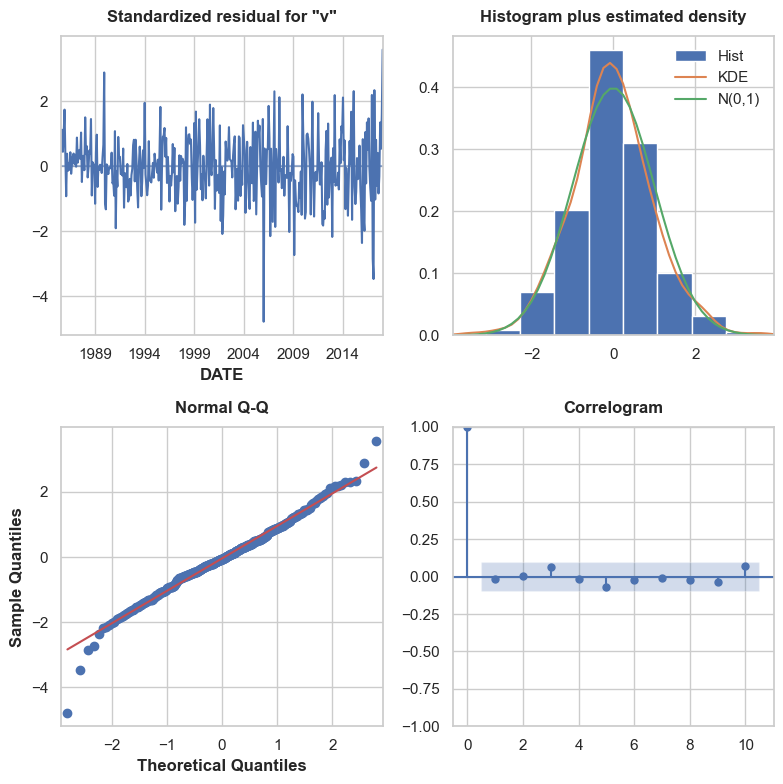

In [53]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

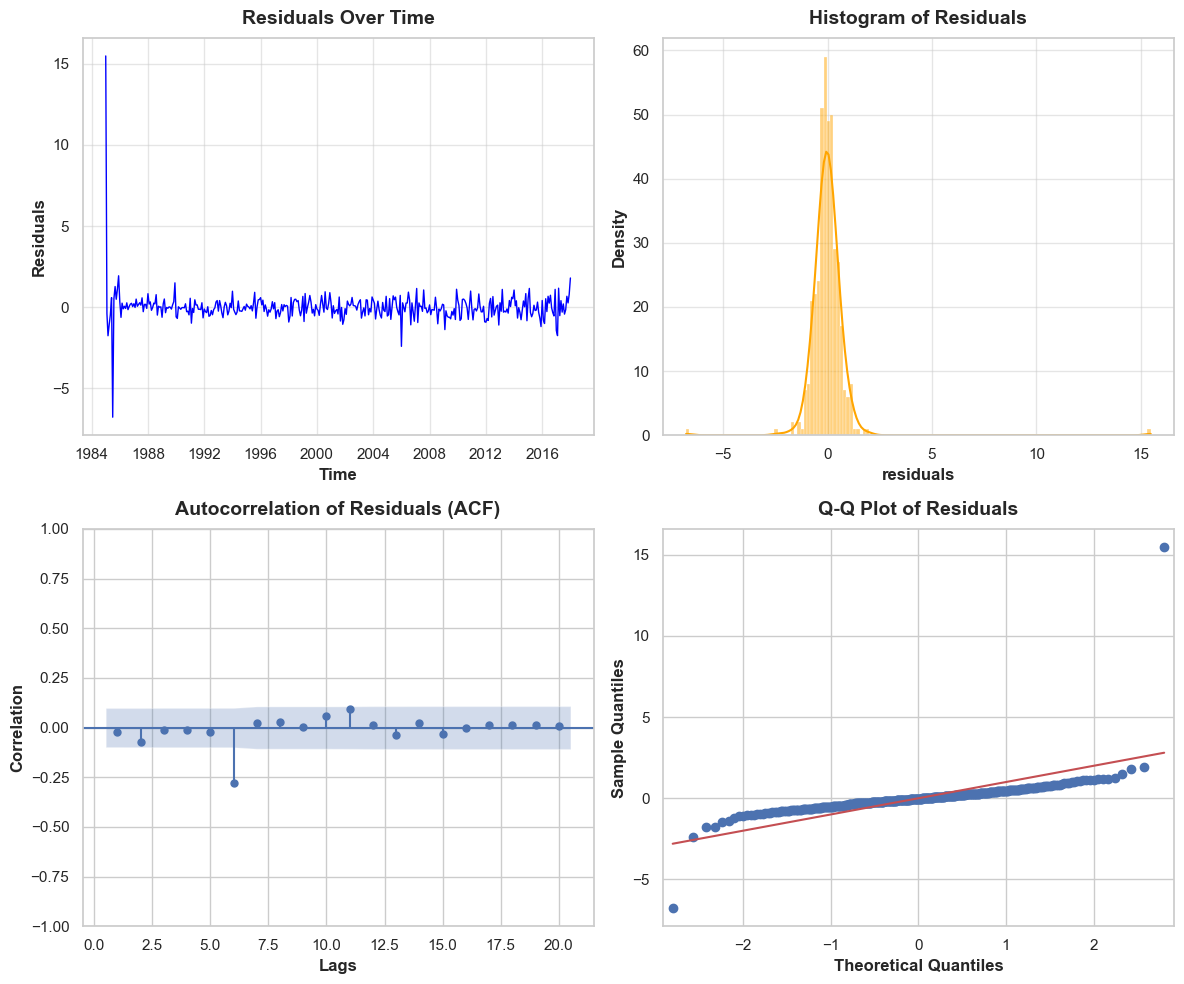

In [54]:
# Extract residuals from the model
residuals = results.resid
# Standardize residuals
standardized_residuals = (residuals - residuals.mean()) / residuals.std()

# Create custom diagnostics plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals Plot
sns.lineplot(x=standardized_residuals.index, y=standardized_residuals, ax=axes[0, 0], color='blue', linewidth=1)
axes[0, 0].set_title("Residuals Over Time", fontsize=14)
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("Residuals")
axes[0, 0].grid(alpha=0.5)

# 2. Histogram of Residuals
sns.histplot(standardized_residuals, kde=True, ax=axes[0, 1], color='orange')
axes[0, 1].set_title("Histogram of Residuals", fontsize=14)
axes[0, 1].set_xlabel("residuals")
axes[0, 1].set_ylabel("Density")
axes[0, 1].grid(alpha=0.5)

# 3. ACF Plot of Residuals
plot_acf(standardized_residuals, lags=20, ax=axes[1, 0], zero=False)
axes[1, 0].set_title("Autocorrelation of Residuals (ACF)", fontsize=14)
axes[1, 0].set_xlabel("Lags")
axes[1, 0].set_ylabel("Correlation")

# 4. Q-Q Plot of Residuals
from statsmodels.graphics.gofplots import qqplot
qqplot(standardized_residuals, line="s", ax=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Residuals", fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()


# **Residual Diagnostics: Interpreting the Diagnostic Plot**

This diagnostic plot provides critical insights into the residuals of your time series model. Let’s interpret each panel of the plot:


## **1. Residuals Over Time (Top Left)**
- **Purpose**: To assess whether residuals are randomly distributed over time.
- **Observations**:
  - Residuals fluctuate around zero for most of the time series, which is good.
  - A noticeable spike occurs at the very beginning of the time series, which may indicate poor model fit for the initial data points or an anomaly.
- **Conclusion**: 
  - For most of the series, the residuals appear random, indicating the model captures the main trends and seasonality.
  - The spike at the beginning warrants investigation (e.g., inspect the corresponding data points for anomalies).

## **2. Histogram of Residuals (Top Right)**
- **Purpose**: To check if residuals are approximately normally distributed.
- **Observations**:
  - The histogram is roughly bell-shaped, but there is a visible asymmetry with a heavier tail on the right.
  - Extreme outliers (e.g., values around 10 and above) are present.
- **Conclusion**:
  - The residuals are close to normal but slightly skewed. This is acceptable for many practical applications, but the extreme outliers may influence the model's performance.

## **3. Autocorrelation of Residuals (ACF) (Bottom Left)**
- **Purpose**: To detect any autocorrelation in residuals (ideally, residuals should resemble white noise).
- **Observations**:
  - Most lags fall within the confidence interval (shaded region), indicating no significant autocorrelation.
  - There is a slight dip at lag 5, but it is still within the confidence bounds.
- **Conclusion**:
  - The absence of significant autocorrelations suggests the model has adequately captured the data's structure.

## **4. Q-Q Plot of Residuals (Bottom Right)**
- **Purpose**: To assess whether residuals follow a normal distribution.
- **Observations**:
  - Residuals mostly align with the diagonal line in the middle of the plot, indicating normality in the bulk of the data.
  - However, the extreme points at the tails deviate significantly, confirming the presence of outliers.
- **Conclusion**:
  - Residuals are mostly normal, but heavy tails indicate outliers or extreme values that deviate from normality.

## **Overall Assessment**
### **Strengths**:
✅ Residuals are mostly random, with no significant autocorrelation.  
✅ The model captures the main structure of the time series effectively.

### **Weaknesses**:
⚠️ Outliers and heavy tails in the residuals suggest potential issues with certain data points or model assumptions.  
⚠️ The spike in residuals at the beginning of the series indicates a poor fit for early observations.


### All the 4 plots indicates a good fit of the SARIMA model on the given time serie.

## SARIMA Prediction

Now we will create a vector that will host the predictions

In [55]:
# Get predictions using `get_prediction()`
prediction = results.get_prediction(start=len(df) - 24, end=len(df) - 1, dynamic=False)
mean_prediction = prediction.predicted_mean
mean_prediction = mean_prediction.rename("prediction")

# Display the predictions
print(mean_prediction)

DATE
2016-02-01    110.429222
2016-03-01    100.043063
2016-04-01     86.866927
2016-05-01     91.993688
2016-06-01    100.872879
2016-07-01    113.348929
2016-08-01    112.060336
2016-09-01    102.934498
2016-10-01     93.038050
2016-11-01     95.404610
2016-12-01    107.617063
2017-01-01    121.587302
2017-02-01    107.675210
2017-03-01     95.539940
2017-04-01     90.778709
2017-05-01     90.182061
2017-06-01    103.563307
2017-07-01    111.200811
2017-08-01    110.914721
2017-09-01     99.347157
2017-10-01     90.451107
2017-11-01     96.084729
2017-12-01    110.968051
2018-01-01    120.963770
Freq: MS, Name: prediction, dtype: float64


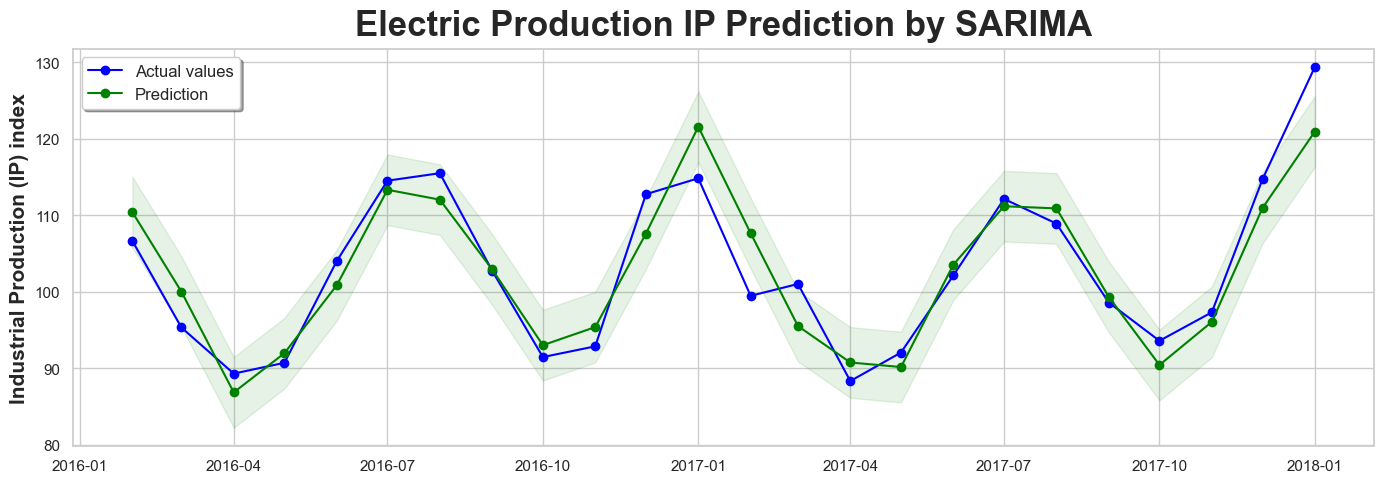

In [56]:
# Ensure the SARIMAX model is fitted before making predictions
model_fitted = model.fit()  # If not already fitted
# Get confidence intervals
confi_int_p = prediction.conf_int()
lower_limits_p = confi_int_p.iloc[:, 0]
upper_limits_p = confi_int_p.iloc[:, 1]

# Plot actual vs. predicted values
plt.figure(figsize=(14,5))
plt.title("Electric Production IP Prediction by SARIMA", fontsize=25)

plt.plot(df[-24:].index, df[-24:].values, label='Actual values', color="blue", marker="o")
plt.plot(mean_prediction.index, mean_prediction.values, label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction.index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()

Moreover, we also get the confidence intervals from the sarima prediction

In [57]:
rmse_sarima = sqrt(mean_squared_error(df[-24:].values,mean_prediction.values))
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

RMSE OF SARIMA MODEL : 3.87


# SARIMA Forecast

In [58]:
prediction_window=12
train = df.copy()

In [59]:
# Make ARIMA forecast of next 10 values (12 steps)
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast = mean_forecast.rename("prediction")

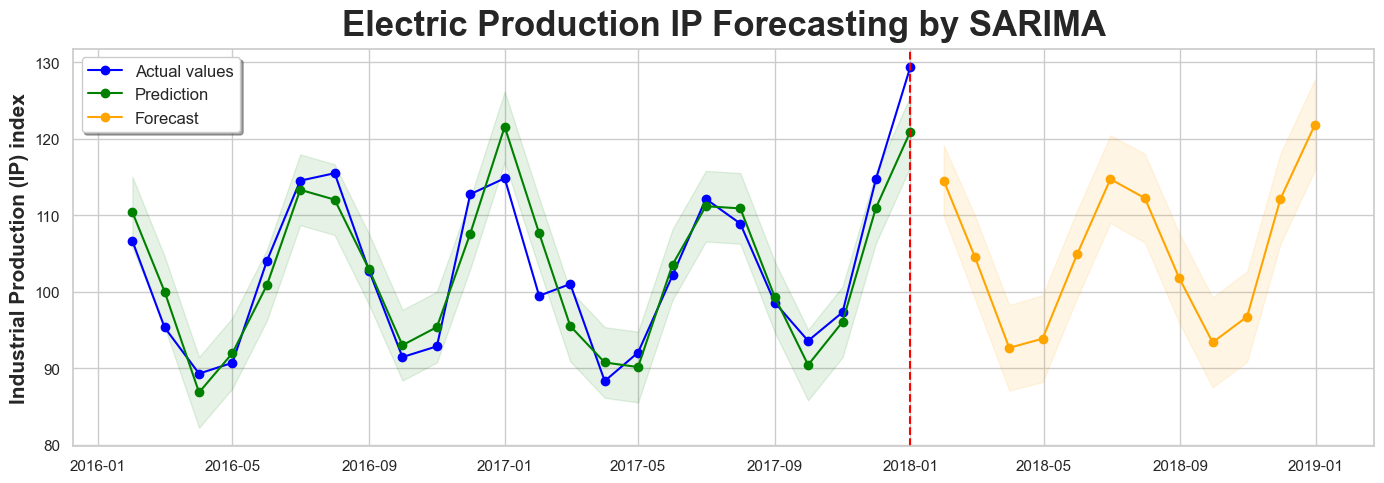

In [60]:
# Get forecast confidence intervals
conf_int_f = forecast.conf_int()
lower_limits_f = conf_int_f.iloc[:, 0]
upper_limits_f = conf_int_f.iloc[:, 1]

# Plot
plt.figure(figsize=(14, 5))
plt.title("Electric Production IP Forecasting by SARIMA", fontsize=25)

# Plot actual values
plt.plot(df[-24:].index, df[-24:].values, label='Actual values', color="blue", marker="o")

# Plot prediction
plt.plot(mean_prediction[-24:].index, mean_prediction[-24:].values, label='Prediction', color="green", marker="o")
plt.fill_between(mean_prediction[-24:].index, lower_limits_p, upper_limits_p, alpha=0.1, color="green")

# Plot forecast
forecast_index = pd.date_range(start=df.index[-1], periods=12, freq='M')  # Adjust based on frequency
plt.plot(forecast_index, mean_forecast.values, label='Forecast', color="orange", marker="o")
plt.fill_between(forecast_index, lower_limits_f, upper_limits_f, alpha=0.1, color="orange")

# Vertical line separating prediction and forecast
plt.axvline(df.index[-1], color="red", linestyle="--")

# Add legend and labels
plt.legend(fontsize=12, fancybox=True, shadow=True, frameon=True)
plt.ylabel('Industrial Production (IP) index', fontsize=15)
plt.show()


AR

In [61]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt

In [62]:
# Grid search for the best lag (p)
best_rmse_ar = float("inf")
best_p = None

for p in range(1, 21):  # Test lag values from 1 to 20
    try:
        ar_model = AutoReg(df, lags=p).fit()
        ar_pred = ar_model.predict(start=len(df) - 24, end=len(df) - 1)
        rmse = sqrt(mean_squared_error(df[-24:], ar_pred))
        if rmse < best_rmse_ar:
            best_rmse_ar = rmse
            best_p = p
    except Exception as e:
        continue

print(f"Best AR Model: p={best_p}, RMSE={best_rmse_ar:.2f}")


Best AR Model: p=18, RMSE=4.70


AR Model RMSE: 4.70


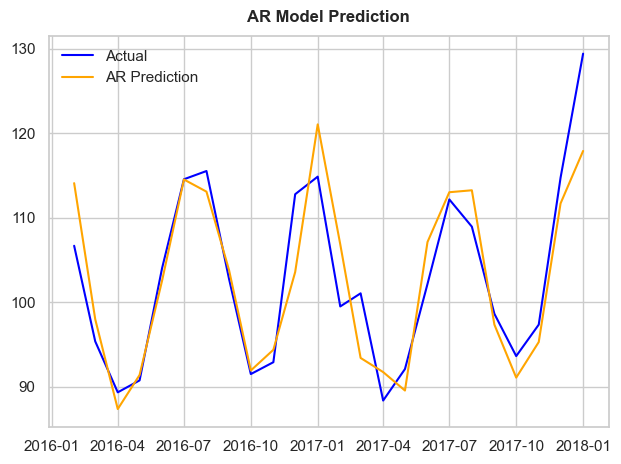

In [63]:
# Fit an AR model
ar_model = AutoReg(df, lags=18).fit()  # Adjust lags as needed
ar_pred = ar_model.predict(start=len(df) - 24, end=len(df) - 1)

# Calculate RMSE
ar_rmse = sqrt(mean_squared_error(df[-24:], ar_pred))
print(f"AR Model RMSE: {ar_rmse:.2f}")

# Plot
plt.plot(df[-24:], label='Actual', color='blue')
plt.plot(ar_pred, label='AR Prediction', color='orange')
plt.title("AR Model Prediction")
plt.legend()
plt.show()


AR Model RMSE: 6.05


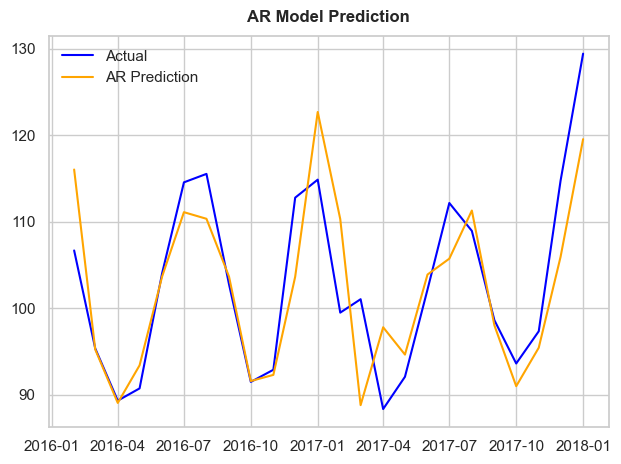

In [64]:
# Fit an AR model
ar_model = AutoReg(df, lags=5).fit()  # Adjust lags as needed
ar_pred = ar_model.predict(start=len(df) - 24, end=len(df) - 1)

# Calculate RMSE
ar_rmse = sqrt(mean_squared_error(df[-24:], ar_pred))
print(f"AR Model RMSE: {ar_rmse:.2f}")

# Plot
plt.plot(df[-24:], label='Actual', color='blue')
plt.plot(ar_pred, label='AR Prediction', color='orange')
plt.title("AR Model Prediction")
plt.legend()
plt.show()


In [65]:
# Grid search for the best q
best_rmse_ma = float("inf")
best_q = None

for q in range(1, 21):  # Test q values from 1 to 20
    try:
        ma_model = ARIMA(df, order=(0, 0, q)).fit()
        ma_pred = ma_model.predict(start=len(df) - 24, end=len(df) - 1)
        rmse = sqrt(mean_squared_error(df[-24:], ma_pred))
        if rmse < best_rmse_ma:
            best_rmse_ma = rmse
            best_q = q
    except Exception as e:
        continue

print(f"Best MA Model: q={best_q}, RMSE={best_rmse_ma:.2f}")

Best MA Model: q=19, RMSE=6.17


MA Model RMSE: 6.17


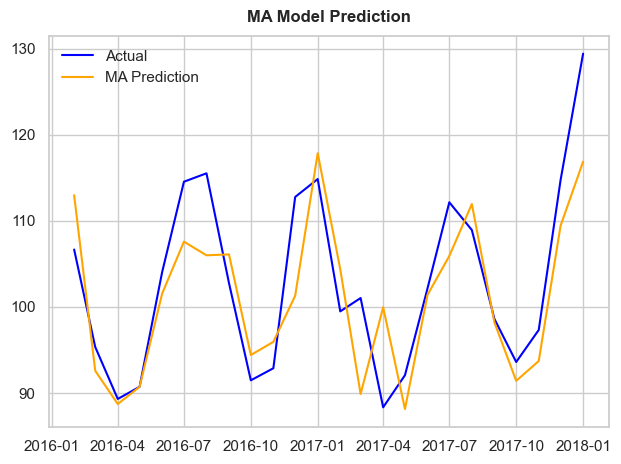

In [66]:
# Fit an MA model
ma_model = ARIMA(df, order=(0, 0, 19)).fit()  # Adjust q in order=(0, 0, q)
ma_pred = ma_model.predict(start=len(df) - 24, end=len(df) - 1)

# Calculate RMSE
ma_rmse = sqrt(mean_squared_error(df[-24:], ma_pred))
print(f"MA Model RMSE: {ma_rmse:.2f}")

# Plot
plt.plot(df[-24:], label='Actual', color='blue')
plt.plot(ma_pred, label='MA Prediction', color='orange')
plt.title("MA Model Prediction")
plt.legend()
plt.show()


In [67]:
# Grid search for the best p and q
best_rmse_arma = float("inf")
best_p_arma = None
best_q_arma = None

for p in range(1, 6):  # Test p values from 1 to 5
    for q in range(1, 6):  # Test q values from 1 to 5
        try:
            arma_model = ARIMA(df, order=(p, 0, q)).fit()
            arma_pred = arma_model.predict(start=len(df) - 24, end=len(df) - 1)
            rmse = sqrt(mean_squared_error(df[-24:], arma_pred))
            if rmse < best_rmse_arma:
                best_rmse_arma = rmse
                best_p_arma = p
                best_q_arma = q
        except Exception as e:
            continue

print(f"Best ARMA Model: p={best_p_arma}, q={best_q_arma}, RMSE={best_rmse_arma:.2f}")


Best ARMA Model: p=4, q=5, RMSE=4.87


ARMA Model RMSE: 4.87


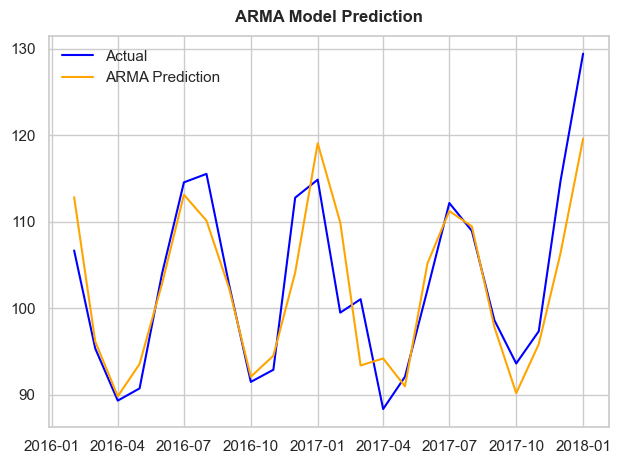

In [68]:
# Fit an ARMA model
arma_model = ARIMA(df, order=(4, 0, 5)).fit()  # Adjust p and q in order=(p, 0, q)
arma_pred = arma_model.predict(start=len(df) - 24, end=len(df) - 1)

# Calculate RMSE
arma_rmse = sqrt(mean_squared_error(df[-24:], arma_pred))
print(f"ARMA Model RMSE: {arma_rmse:.2f}")

# Plot
plt.plot(df[-24:], label='Actual', color='blue')
plt.plot(arma_pred, label='ARMA Prediction', color='orange')
plt.title("ARMA Model Prediction")
plt.legend()
plt.show()


In [69]:
# Grid search for the best p, d, and q
best_rmse_arima = float("inf")
best_p_arima = None
best_d_arima = None
best_q_arima = None

for p in range(1, 6):  # Test p values from 1 to 5
    for d in range(0, 3):  # Test d values from 0 to 2
        for q in range(1, 6):  # Test q values from 1 to 5
            try:
                arima_model = ARIMA(df, order=(p, d, q)).fit()
                arima_pred = arima_model.predict(start=len(df) - 24, end=len(df) - 1, typ='levels')
                rmse = sqrt(mean_squared_error(df[-24:], arima_pred))
                if rmse < best_rmse_arima:
                    best_rmse_arima = rmse
                    best_p_arima = p
                    best_d_arima = d
                    best_q_arima = q
            except Exception as e:
                continue

print(f"Best ARIMA Model: p={best_p_arima}, d={best_d_arima}, q={best_q_arima}, RMSE={best_rmse_arima:.2f}")

Best ARIMA Model: p=5, d=1, q=5, RMSE=4.81


ARIMA Model RMSE: 4.81


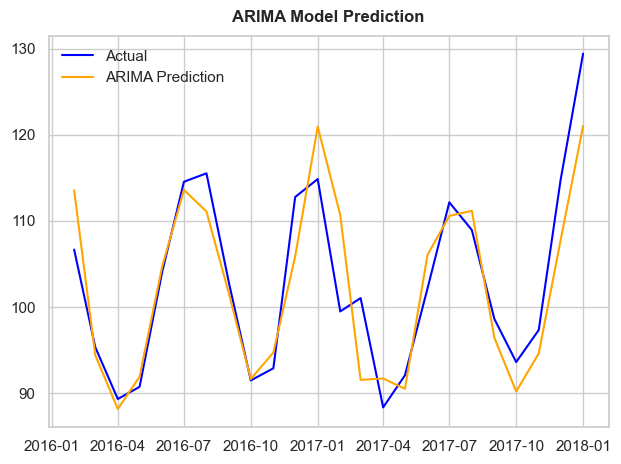

In [83]:
# Fit an ARIMA model
arima_model = ARIMA(df, order=(5, 1, 5)).fit()  # Adjust p, d, q in order=(p, d, q)
arima_pred = arima_model.predict(start=len(df) - 24, end=len(df) - 1, typ='levels')

# Calculate RMSE
arima_rmse = sqrt(mean_squared_error(df[-24:], arima_pred))
print(f"ARIMA Model RMSE: {arima_rmse:.2f}")

# Plot
plt.plot(df[-24:], label='Actual', color='blue')
plt.plot(arima_pred, label='ARIMA Prediction', color='orange')
plt.title("ARIMA Model Prediction")
plt.legend()
plt.show()


In [84]:
print("Model Comparison:")
print(f"AR Model RMSE: {ar_rmse:.2f}")
print(f"MA Model RMSE: {ma_rmse:.2f}")
print(f"ARMA Model RMSE: {arma_rmse:.2f}")
print(f"ARIMA Model RMSE: {arima_rmse:.2f}")
print(f"RMSE OF SARIMA MODEL : {rmse_sarima:.2f}")

Model Comparison:
AR Model RMSE: 6.05
MA Model RMSE: 6.17
ARMA Model RMSE: 4.87
ARIMA Model RMSE: 4.81
RMSE OF SARIMA MODEL : 3.87


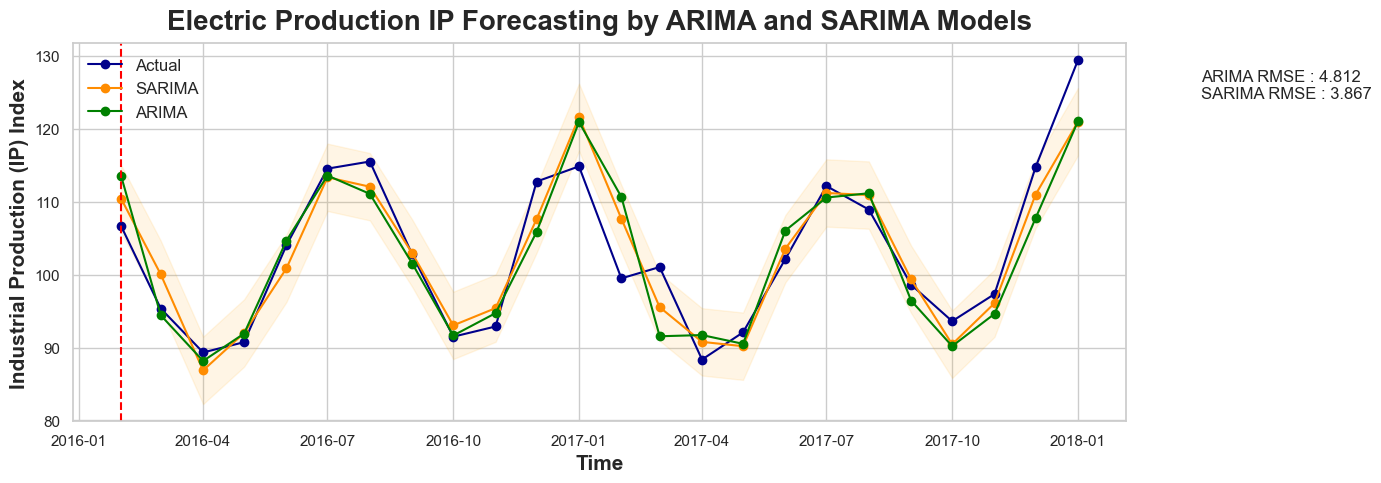

In [89]:
#plt.figure(figsize=(10, 5.63)) powepoint 
plt.figure(figsize=(14, 5))
plt.title("Electric Production IP Forecasting by ARIMA and SARIMA Models", fontsize=20)

# Plot actual values
plt.plot(df[-24:].index, df[-24:].values, color='darkblue', label='Actual', marker='o')

# Plot SARIMA predictions
plt.plot(mean_prediction.index, mean_prediction.values, color='darkorange', label='SARIMA', marker='o')
plt.fill_between(mean_prediction.index, lower_limits_p, upper_limits_p, alpha=0.1, color='orange')

# Plot ARIMA predictions
plt.plot(arima_pred.index, arima_pred.values, color='green', label='ARIMA', marker='o')

# Vertical line to separate train/test
plt.axvline(df.index[-24], color="red", linestyle="--")

# Add legend
plt.legend(loc='upper left', fontsize=12)

# Add RMSE and MAPE text box
text = (
    f"ARIMA RMSE : {arima_rmse:.3f}\n"
    f"SARIMA RMSE : {rmse_sarima:.3f}\n\n"
)
plt.text(df.index[-1] + pd.DateOffset(months=3), df.max() - 10, text,
         fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

# Add labels
plt.ylabel('Industrial Production (IP) Index', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.tight_layout()
plt.show()


### **Model Evaluation and Recommendations**

#### **Model Accuracy**
- The **SARIMA model (RMSE = 3.867)** outperforms the **ARIMA model (RMSE = 4.812)** in terms of prediction accuracy.
- This is expected since **SARIMA incorporates seasonality**, which is a crucial feature in the dataset.

#### **Seasonality Handling**
- The SARIMA model captures **seasonal fluctuations better than ARIMA**, as evident in its closer alignment with the actual data during peaks and troughs.

### **Actionable Recommendations**

#### ✅ **Prefer SARIMA Over ARIMA**
- Since **SARIMA explicitly models seasonality**, it is the better choice for this dataset.

#### 🔧 **Fine-Tune SARIMA Parameters**
- Perform **additional tuning of SARIMA hyperparameters** to potentially reduce RMSE further.

#### 🔍 **Test Alternative Models**
- Consider testing models like **Prophet or LSTM** for comparison, especially if you expect **non-linear trends or complex relationships**.
